# InSituPy Demonstration - Build an InSituData Object from Scratch

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import geopandas as gpd
import dask.array as da
from shapely.geometry import Polygon
from insitupy import InSituData
from insitupy._core.dataclasses import CellData, BoundariesData, ImageData, AnnotationsData, RegionsData
from pathlib import Path

### Let's start by generating main modalities and adding them into InSituData

#### First, let's generate an H&E-like random numpy image

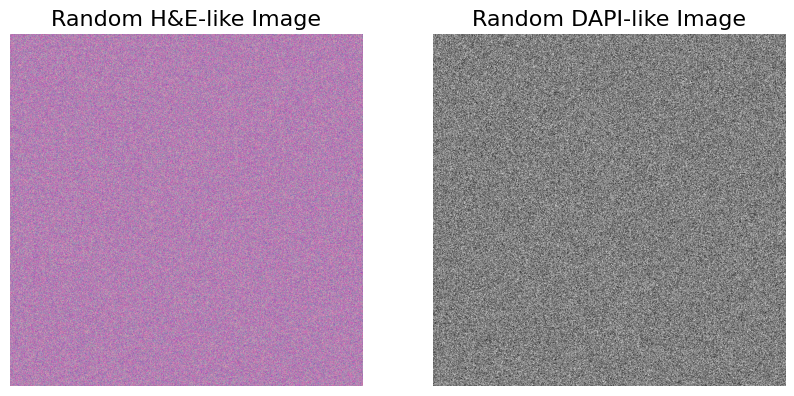

In [3]:
x_size = 1000
y_size = 1000
n_cells = 250
pixel_size = 0.2125

# Function to generate a random H&E-like image
def generate_random_he_image(height, width):
    # Hematoxylin (blue-purple) and Eosin (pink) color ranges
    hematoxylin_color = np.array([0.4, 0.2, 0.6])
    eosin_color = np.array([1.0, 0.8, 0.8])

    random_image = np.random.rand(height, width, 3)
    he_image = random_image * hematoxylin_color + (1 - random_image) * eosin_color

    return he_image

# Function to generate a random grayscale DAPI-like image
def generate_random_dapi_image(height, width):
    # DAPI (blue) color range in grayscale
    dapi_color = np.array([0.1, 0.1, 0.8])

    random_image = np.random.rand(height, width)
    dapi_image = random_image * dapi_color[2]  # Use the blue channel for grayscale

    return dapi_image

# Generate H&E-like image
he_image = generate_random_he_image(x_size, y_size)

# Generate DAPI-like image
dapi_image = generate_random_dapi_image(x_size, y_size)

# Display the generated images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(he_image)
plt.title("Random H&E-like Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dapi_image, cmap='gray')
plt.title("Random DAPI-like Image")
plt.axis('off')

plt.show()

#### In the next step we generate an `AnnData` object with respective spatial coordinates and a `Dask` Array with cellular boundaries for the respective cells.

In [4]:
pixel_coordinates = np.random.rand(n_cells, 2) * [x_size, y_size]

# Convert pixel coordinates to micrometers (1 pixel = 0.2125 micrometers)
micrometer_coordinates = pixel_coordinates * pixel_size

# Generate random gene expression counts matrix (n_cells x num_genes)
num_genes = 10
gene_counts = np.random.poisson(lam=5, size=(n_cells, num_genes))

# Create an AnnData object with gene expression counts and spatial coordinates
adata = ad.AnnData(X=gene_counts)
adata.obsm['spatial'] = micrometer_coordinates
# Example observations (metadata)
obs_data = {
    'cell_type': ['type1', 'type2'] * (n_cells // 2),  # Example cell types
    'batch': ['batch1'] * (n_cells // 2) + ['batch2'] * (n_cells // 2)  # Example batch information
}

# Add observations to the obs attribute
adata.obs = adata.obs.assign(**obs_data)
adata

AnnData object with n_obs × n_vars = 250 × 10
    obs: 'cell_type', 'batch'
    obsm: 'spatial'

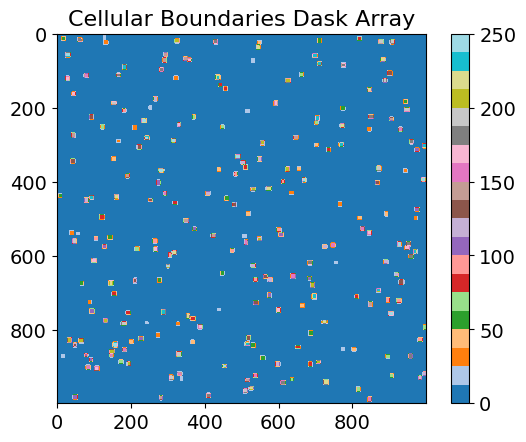

In [5]:
# Function to generate a cellular boundaries Dask array
def generate_cellular_boundaries_array(height, width, num_cells):
    # Initialize an empty array with zeros
    array = np.zeros((height, width), dtype=int)

    # Randomly generate cell boundaries and assign cell IDs
    for cell_id in range(1, num_cells + 1):
        while True:
            # Randomly choose the top-left corner of the cell
            top_left_x = np.random.randint(0, height - 5)
            top_left_y = np.random.randint(0, width - 5)

            # Randomly choose the size of the cell
            cell_height = np.random.randint(10, 15)
            cell_width = np.random.randint(10, 15)

            # Check if the chosen region is empty (no intersection with other cells)
            if np.all(array[top_left_x:top_left_x + cell_height, top_left_y:top_left_y + cell_width] == 0):
                # Assign the cell ID to the chosen region
                array[top_left_x:top_left_x + cell_height, top_left_y:top_left_y + cell_width] = cell_id
                break

    # Convert the NumPy array to a Dask array with chunks
    dask_array = da.from_array(array, chunks=(50, 50))

    return dask_array

# Generate a cellular boundaries Dask array
cellular_boundaries_array = generate_cellular_boundaries_array(y_size, x_size, n_cells)

# Compute the Dask array to get a NumPy array
numpy_array = cellular_boundaries_array.compute()

# Plot the NumPy array
plt.imshow(numpy_array, cmap='tab20')
plt.title("Cellular Boundaries Dask Array")
plt.colorbar()
plt.show()

#### Let's also generate example annotations and regions

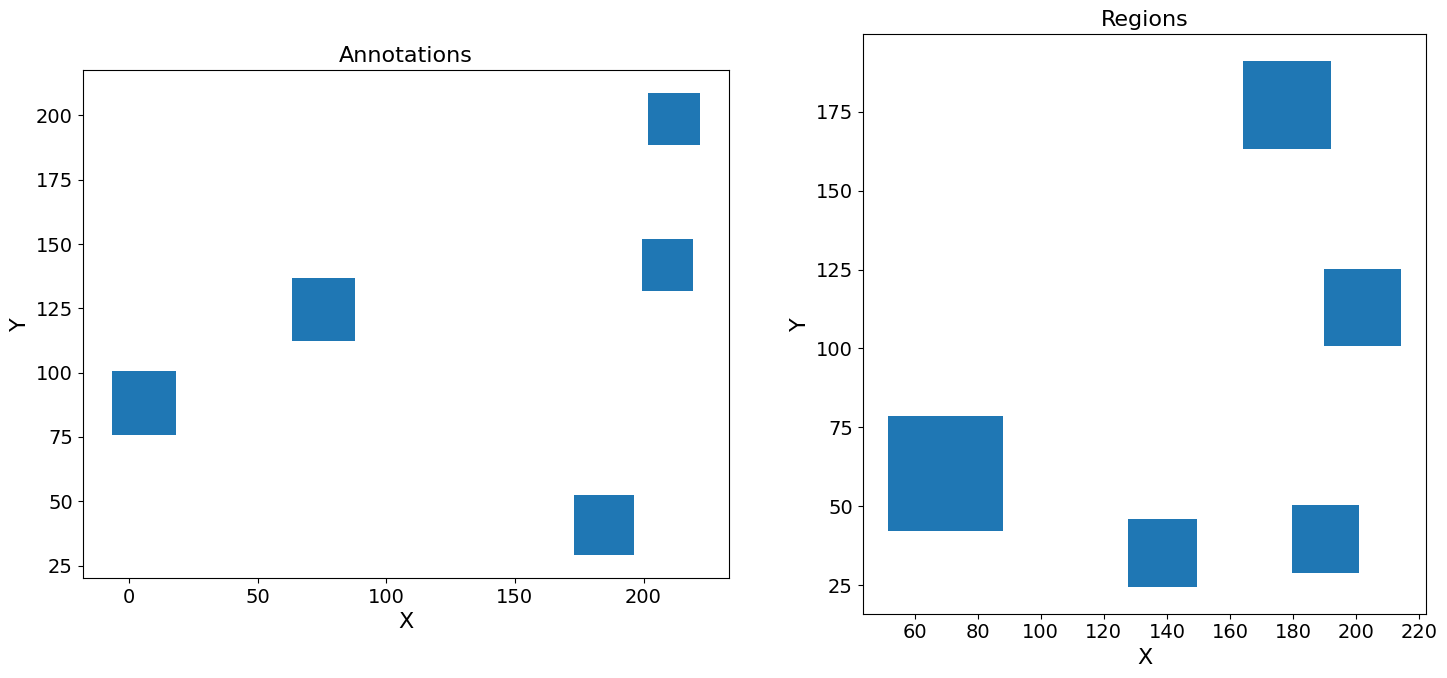

In [14]:
# Function to generate random polygons
def generate_random_polygons(num_polygons, x_size, y_size):
    polygons = []
    attempts = 0
    max_attempts = num_polygons * 10  # Limit the number of attempts to avoid infinite loop

    while len(polygons) < num_polygons and attempts < max_attempts:
        # Generate random center point
        center_x = np.random.uniform(0, x_size)
        center_y = np.random.uniform(0, y_size)

        # Generate random size for the polygon
        size = np.random.uniform(10, 20)

        # Create a square polygon around the center point
        polygon = Polygon([
            (center_x - size, center_y - size),
            (center_x + size, center_y - size),
            (center_x + size, center_y + size),
            (center_x - size, center_y + size)
        ])

        # Check if the new polygon intersects with any existing polygons
        if not any(polygon.intersects(existing_polygon) for existing_polygon in polygons):
            polygons.append(polygon)

        attempts += 1

    return polygons
# Generate random polygons
num_polygons = 5
random_polygons = generate_random_polygons(num_polygons, x_size*pixel_size, y_size*pixel_size)
# Create GeoDataFrame with random polygons
gdf_annotations = gpd.GeoDataFrame(geometry=random_polygons)
gdf_annotations["id"] = gdf_annotations.index
gdf_annotations["name"] = ['annotation1'] * (num_polygons // 2) + ['annotation2'] * (num_polygons - (num_polygons // 2))


random_polygons = generate_random_polygons(num_polygons, x_size*pixel_size, y_size*pixel_size)
# Create GeoDataFrame with random polygons
gdf_regions = gpd.GeoDataFrame(geometry=random_polygons)
gdf_regions["id"] = gdf_regions.index
gdf_regions["name"] = gdf_regions.index

# Plot the two GeoDataFrames in one row
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

gdf_annotations.plot(ax=axes[0])
axes[0].set_title("Annotations")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

gdf_regions.plot(ax=axes[1])
axes[1].set_title("Regions")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")

plt.tight_layout()
plt.show()


In [15]:
# Print the GeoDataFrame with random polygons
print(gdf_annotations.head())
print(gdf_regions.head())

                                            geometry  id         name
0  POLYGON ((-6.655 75.861, 18.226 75.861, 18.226...   0  annotation1
1  POLYGON ((63.512 112.457, 87.842 112.457, 87.8...   1  annotation1
2  POLYGON ((201.607 188.353, 221.968 188.353, 22...   2  annotation2
3  POLYGON ((172.888 29.086, 196.217 29.086, 196....   3  annotation2
4  POLYGON ((199.332 131.828, 219.367 131.828, 21...   4  annotation2
                                            geometry  id  name
0  POLYGON ((51.635 42.135, 88.122 42.135, 88.122...   0     0
1  POLYGON ((127.703 24.253, 149.422 24.253, 149....   1     1
2  POLYGON ((189.690 100.687, 214.172 100.687, 21...   2     2
3  POLYGON ((179.515 28.965, 201.015 28.965, 201....   3     3
4  POLYGON ((164.011 163.358, 191.902 163.358, 19...   4     4


## Finally we create an `InSituData` object with all the modalities we have generated before

First we initialize an empty `InSituData` object with some metadata information.

In [21]:
xd = InSituData(
    path=Path("dummy_path"),
    metadata={"metadata_file": Path("./")},
    method="scST",
    slide_id="slide",
    sample_id="sample_1",
    from_insitudata=False
    )

In [22]:
xd

InSituData
Method:		scST
Slide ID:	slide
Sample ID:	sample_1
Path:		dummy_path
Metadata file:	.

No modalities available.

Then we add the data in the correct format. A `CellData` object consists of (i) the transcriptomic data as `AnnData` object and (ii) the cellular and/or nuclear boundaries as `BoundariesData` object.

In [27]:
# set up the boundaries data object
bd = BoundariesData(cell_ids=None, seg_mask_value=None)
bd.add_boundaries(data={"cellular": cellular_boundaries_array}, pixel_size=pixel_size)

# set up the object for the cellular data based on the anndata object and the boundaries object
cd = CellData(matrix=adata, boundaries=bd)
xd.cells = cd

Images are stored in an `ImageData` object:

In [ ]:

# add an empty ImageData object and add the generated images
xd.images = ImageData()
xd.images.add_image(image=he_image, name="H&E", axes="xyc", pixel_size=pixel_size, ome_meta={'PhysicalSizeX': pixel_size})
xd.images.add_image(image=dapi_image, name="nuclei", axes="xyc", pixel_size=pixel_size, ome_meta={'PhysicalSizeX': pixel_size})

... and annotations and regions as `AnnotationsData` or `RegionsData`, respectively.

In [24]:
# add the annotations and regions data
xd.annotations = AnnotationsData()
xd.annotations.add_data(gdf_annotations, key="example_annotation", scale_factor=1)

xd.regions = RegionsData()
xd.regions.add_data(gdf_regions, key="example_regions", scale_factor=1)

In [25]:
xd

InSituData
Method:		scST
Slide ID:	slide
Sample ID:	sample_1
Path:		dummy_path
Metadata file:	.
    ➤ images
       H&E:	(1000, 1000, 3)
       nuclei:	(1000, 1000)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 250 × 10
           obs: 'cell_type', 'batch'
           obsm: 'spatial'
       boundaries
           BoundariesData object with 1 entry:
               cellular
    ➤ annotations
       example_annotation:	5 annotations, 2 classes ('annotation1','annotation2') 
    ➤ regions
       example_regions:	5 regions, 5 classes ('0','1','2','3','4') 

### Visualize the data using the napari-viewer

In [26]:
xd.show()

C:\Users\ge37voy\Github\InSituPy\insitupy\images\utils.py:203: UserWarning: Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.
  warnings.warn("Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.")
C:\Users\ge37voy\Github\InSituPy\insitupy\images\utils.py:203: UserWarning: Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.
  warnings.warn("Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.")
